In [1]:
%pip install langdetect
%pip install inflect
%pip install stop_words==2018.7.23

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Proyecto 1 inteligencia de negocios

Integrantes:

- Brian Manuel Rivera

- Tony Santiago Montes

- Luccas Rojas

Como negocio vamos a asumir que vamos a ayudar a una empresa que vende un servicio de subscripción para ver películas en streaming como por ejemplo Netflix. Podemos ayudar a Netflix a mejorar su proceso de selección de películas, esto a través de generar un modelo que le ayude a predecir si una reseña de una película es positiva o negativa. Revisando así las reseñas de forma automática y ayudando al proceso de seleccion de las peliculas

## Entendimiento del negocio y enfoque analítico

### Objetivos:

Nuestro principal objetivo va a ser poder predecir si una reseña de una película es positiva o negativa. Esto con el fin de que la empresa interesada pueda usar esta información para por ejemplo decidir que películas meter a una plataforma de streaming o que películas bajar de dicha plataforma por tener malas reseñas de los clientes. 

### Criterios de éxito:

Nuestros criterios de éxito estarán dados por cuántas reseñas podemos clasificar de manera correcta entre reseñas positivas y reseñas negativas. Esto será cuantificado a través de un porcentaje que presenta el número de películas que son clasificadas correctamente sobre el total de películas a clasificar.

### Técnicas y algoritmos:

Para poder lograr casificar las reseñas entre positivas y negativas a través del aprendizaje automático vamos a utilizar distintos algorítmos de clasificación, como lo son Regresión Logística, Naive Bayes y SVM. Evaluaremos el comportamiento de los 3 algorítmos para así poder mejorar la predicción entregada. Esto nos permitirá a través de un proceso de entrenamiento generar un modelo que nos permitirá predecir si una reseña nueva es positiva o negativa.

### Oportunidad:

Como empresa observamos que este proyecto tiene una gran oportunidad de negocio, ya que con el modelo de aprendizaje automático que deseamos desarrollar la empresa podrá aumentar su número de clientes y así sus ganancias. Esto ya que va a ser capaz de tener mejor contenido en su sitio de streaming y así atraer más clientes.

### Beneficiados:

El beneificiario es la organización que va a poder utilizar la información entregada por el modelo para tomar desiciones que aporten al crecimiento del negocio. 

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import string
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
import nltk
import unicodedata
import re
from sklearn.svm import SVC
import inflect
from nltk.stem import PorterStemmer
from joblib import Parallel, delayed
import os
import scipy as sp
from sklearn.pipeline import Pipeline, make_pipeline
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score 
nltk.download('stopwords')

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tony\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Carga de datos 

In [3]:
data = pd.read_csv('data/MovieReviews.csv')

In [4]:
data.shape

(5000, 3)

Mostrar ejemplo de los datos

In [5]:
data.sample(10)

,Unnamed: 0,review_es,sentimiento
2571,2571,Las bragas de la niña olfatea matan a un chico...,negativo
1012,1012,"¿Qué tan bueno es esta película?Aparentemente,...",positivo
3988,3988,Logré evitar leer Hemingway en la universidad....,negativo
619,619,Fiel a la obra de Pearl S. Buck cuyos años pas...,positivo
64,64,¿Quién dijo que el horror no era un género de ...,positivo
4109,4109,Esto es sin duda la peor película que he visto...,negativo
51,51,"Dos mujeres, enfermo de sus esposos controlado...",positivo
2061,2061,El grupo de personas viajan a Belgrado en un a...,positivo
2129,2129,Para citar a Jason Connery y Mark Ryan en uno ...,positivo
4580,4580,"Por supuesto, no soy el connoisseur d'horror, ...",negativo


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   5000 non-null   int64 
 1   review_es    5000 non-null   object
 2   sentimiento  5000 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


Se asegura el idioma de los datos, para que estos tengan solo el idioma español.

In [7]:
# Creamos una nueva columna para almacenar el idioma detectado
data['idioma'] = data['review_es'].apply(detect)

# Calculamos la proporción de cada idioma
proporcion_idiomas = data['idioma'].value_counts(normalize=True)
print(proporcion_idiomas)

es    0.9606
en    0.0392
id    0.0002
Name: idioma, dtype: float64


# 2. Limpieza y preparacion

In [8]:
#Copiamos los datos para no modificar los datos orginiales
data_clean = data.copy(deep=True)

Cambiar la variable resultado a un booleano, donde 0 sea negativo y 1 sea positivo

In [9]:
dict_conversion={"positivo":1,"negativo":0}
data_clean["sentimiento"] = data_clean["sentimiento"].map(dict_conversion)

In [10]:
data.describe()

,Unnamed: 0
count,5000.000000
mean,2499.500000
std,1443.520003
min,0.000000
25%,1249.750000
50%,2499.500000
75%,3749.250000
max,4999.000000


Cómo podemos ver nos encontramos con una columna numérica que no aporta información.

In [11]:
numeric_cols = data_clean.select_dtypes(include=['int64', 'float64'])
categorical_cols = data_clean.select_dtypes(include=['object'])

## 2.1 Unicidad

In [12]:
data_clean.duplicated().sum()

0

No hay opiniones que sean exactamente iguales entre las películas.

## 2.2 Completitud

In [13]:
#Revisar la cantidad de nulos
data_clean.isnull().sum()

Unnamed: 0     0
review_es      0
sentimiento    0
idioma         0
dtype: int64

No hay datos nulos.

## 2.3 Consistencia 

Para este caso confiamos en la consistencia de la fuente, ya que nos es complicado verificar la consistencia

## 2.4 Validez

In [14]:
possible_values = {i:'' for i in data_clean.columns if 'Unnamed' not in i}

for col in numeric_cols:
    possible_values[col] = f"[{data[col].min()}, {data[col].max()}]"

for col in categorical_cols:
    possible_values[col] = str(data[col].unique())

for k,v in possible_values.items():
    print(f"{k} : {v}")

review_es : ['Si está buscando una película de guerra típica, esta no es así, por lo que una nota a todos los aficionados a la guerra de ansiancia de carnajería de testosterona, no se molesten.Aunque la película se trata de personajes rusos en la Segunda Guerra Mundial, no espere ver a ningún nazis, cañones, sangre, sangre, etc. No es una película sobre las personas que causan una guerra o que luchan contra una guerra.Es una película sobre las personas ordinarias que le ocurren la guerra y las elecciones que hacen para tratar con ella. Cinematografía, escritura: todos los 10s perfectos aquí.Sin duda, lo apreciarás si eres ruso como yo, pero incluso si no, probablemente lo ames.Si no habla ruso, busque la versión DVD del DVD de Ruscico (Russian Cinema Cinema).Tiene subtítulos en unos 14 idiomas diferentes, pero el doblaje inglés en este que diría es igual de bueno.Por supuesto, no es tan bueno como la pista rusa original (algunas cosas se pierden en la traducción), sino tan buenas como 

Exceptuando la columna de unnamed: 0, los datos parecen estar en un formato adecuado que permita la visualización y el tratamiento de los datos.

Observar la distribucion de reseñas

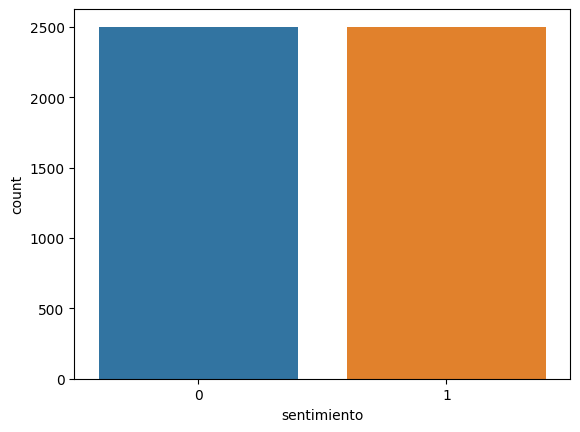

In [15]:
ax = sns.countplot(x="sentimiento", data=data_clean)

Limpieza de columnas sin valor.

In [16]:
data_clean.drop(["Unnamed: 0"], axis=1, inplace=True)

In [17]:
data_clean

,review_es,sentimiento,idioma
0,Si está buscando una película de guerra típica...,1,es
1,Supongo que algunos directores de películas de...,1,es
2,Es difícil contarle más sobre esta película si...,1,es
3,"La película comienza muy lentamente, con el es...",1,es
4,Esta película es verdadera acción en su máxima...,1,es
...,...,...,...
4995,"""Criminal decente ordinario"" es triste porque ...",0,es
4996,Savage Island (2003) es una película coja.Es m...,0,es
4997,Quien escribió el script para esta película no...,0,es
4998,in a TV-movie 70's kind of way It's one of tho...,0,en


Se borran los registros de otros idiomas debido a que son una minoría en los datos, además 

In [18]:
#borrar filas que tengan idioma diferente a español
data_clean = data_clean[data_clean['idioma'] == 'es']
print(data_clean['idioma'].value_counts(normalize=True))

es    1.0
Name: idioma, dtype: float64


# 2.5 Transformacion de los datos

Funciones para limpiar la información

In [19]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    return words

Se aplica la limpieza de datos a cada uno de las reviews de forma paralelizada distribuida en los nucleos de la CPU, se aplica el stemmer de porter antes de aplicarle la limpieza a los datos.

In [20]:
stemmer = SnowballStemmer('spanish')
def porter_stemmer_spanish(text):
    return [stemmer.stem(word) for word in text.split()]

def process_data(data):
    return data.apply(porter_stemmer_spanish).apply(preprocessing)

num_processes = os.cpu_count()
data_split = np.array_split(data_clean, num_processes)
data_clean['review_es'] = pd.concat(Parallel(n_jobs=num_processes)(delayed(process_data)(split['review_es']) for split in data_split))

def join_words(words):
    return ' '.join(words)

data_clean['review_es'] = data_clean['review_es'].apply(join_words)
# esta celda puede tardar hasta 10 minutos

C:\Users\Tony\AppData\Local\Temp\ipykernel_35876\2145623767.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['review_es'] = pd.concat(Parallel(n_jobs=num_processes)(delayed(process_data)(split['review_es']) for split in data_split))
C:\Users\Tony\AppData\Local\Temp\ipykernel_35876\2145623767.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['review_es'] = data_clean['review_es'].apply(join_words)


In [21]:
data_clean.to_csv('data/data_cleaned.csv', index=False)
print(data_clean)

                                              review_es  sentimiento idioma
0     si esta busc una pelicul de guerr tipica esta ...            1     es
1     supong que algun director de pelicul de luj es...            1     es
2     es dificil cont mas sobr esta pelicul sin estr...            1     es
3     la pelicul comienz muy lentamente con el estil...            1     es
4     esta pelicul es verdader accion en su maxim ex...            1     es
...                                                 ...          ...    ...
4994  las bonit visual y much pel no hac una buen pe...            0     es
4995  criminal decent ordinario es trist porqu obvi ...            0     es
4996  savag island 2003 es una pelicul coja mas com ...            0     es
4997  qui escrib el script par esta pelicul no merec...            0     es
4999  pelicul decepcionante predec en la que una muj...            0     es

[4803 rows x 3 columns]


Como se puede apreciar la información se encuentra lista para realizar los entrenamientos correspondientes de los modelos.

# Entendimiento y preparación de los datos.

### Unicidad:

Pudimos notar que no había reseñas duplicadas, por lo que los datos contaban con total unicidad.

### Completitud:

Notamos tambíen que no habían datos nulos dentro de los datos entregados, por lo que contamos ocn datos completos que por el momento podríamos utilizar.

### Consistencia:

Para este caso confiamos en la fuente que nos proporcionó los y así en su consistencia.

### Validez:

La mayoría de los datos parecen estar entregados de forma correcta y cumplen con los criterios del negocio, no obstante hay unas excepciones, como reseñas en inglés que son datos que van a ser removidos para no afectar el modelo generado.

## Preparación de los datos

En nuestro proceso para preparar los datos, lo primero que hicimos fue revisar la cantidad de reseñas escritas en inglés, más que todo para saber si era o no un procentaje significativo. Luego hicimos varios pasos para perfeccionar los datos antes de entrenar el modelo que fueron:

1. Convertir nuestra variable resultado de string a numérica, donde 0 es negativa y 1 positiva para así poder entrenar los diferentes modelos

2. Quitar todos los caracteres que no fueran ASCII de las reseñas 

undefined. Convertir todos las palabras a minúsculas para unificar palabras que contengan minusculas y mayusculas bajo la misma semántica.

undefined. Eliminar la puntuación de las plabras, de igual forma que lo anterior para unificar al semántica de palabras que tienen puntuación.

undefined. Cambiar los números a texto para mantener la unicidad.

undefined. Remover las "stop words" que hacen referencia a todas aquellas palabras que tienen una correlación muy baja o nula con la variable de salida que es el sentimiento. Esto se hace eliminando conectores y artículos de los textos.

undefined. El proceso de verctorizar la reseña lo dejamos dentro del pipeline

# 3. Entrenamiento de modelos

Para poder generar un modelo óptimo que le permita a la empresa sacar de manera precisa la categoría de una reseña, vamos a implementar 3 algorítmos de clasificación que son planteados posteriormente, además vamos a realizar un gridsearch sobre cada algoritmo para asegurarnos de que los hiperparámetros escogidos para cada uno de los algoritmos sean los mejores.

Establecimiento de conjuntos de prueba 

In [22]:
review = data_clean["review_es"]
sentimiento = data_clean["sentimiento"]

X_train, X_test, y_train, y_test = train_test_split(review, sentimiento, test_size=0.2, random_state=42, stratify=sentimiento)
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

## 3.1. Regresión Logística

El algoritmo de regresión logística es una buena opción para clasificar opiniones binarias de películas, ya que puede predecir si una opinión es positiva o negativa. Por ejemplo, si queremos clasificar comentarios de películas como positivos o negativos, podemos utilizar un modelo de regresión logística para entrenar un clasificador basado en características de los comentarios. El modelo podría utilizar características como el número de palabras positivas y negativas en el comentario, la presencia de palabras clave relacionadas con la trama o el género de la película, entre otros. El modelo puede luego predecir la probabilidad de que un comentario sea positivo o negativo. Con esta información, podemos determinar si una opinión es mayoritariamente positiva o negativa y usar esta información para tomar decisiones.

### Modelado

Esta implementación utiliza la regresión logística como algoritmo de clasificación, el cual es adecuado para problemas de clasificación binaria como la clasificación de opiniones de películas. Se utiliza la técnica de vectorización TfidfVectorizer para convertir el texto en características numéricas y se integra en una tubería junto con la regresión logística. Además, se utiliza la búsqueda en cuadrícula para encontrar los mejores valores de los parámetros del modelo. La regresión logística es fácil de implementar y puede proporcionar probabilidades de clasificación en lugar de simples predicciones binarias, lo que es útil para la evaluación del modelo. La combinación de la regresión logística, la vectorización TfidfVectorizer y la búsqueda en cuadrícula permite obtener una alta precisión en la clasificación de opiniones de películas.

In [23]:
params_logreg = {'clf__C': [10,1]}

X_train, X_test, y_train, y_test = train_test_split(review, sentimiento, test_size=0.20)

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=5, max_df=0.7)

lr_tfidf = Pipeline([('vect', tfidf),
                      ('clf', LogisticRegression())])

lr_tfidf = GridSearchCV(lr_tfidf, params_logreg, cv=particiones, n_jobs=-1)
lr_tfidf.fit(X_train, y_train)

score = lr_tfidf.score(X_test, y_test)
print("Best params: ",lr_tfidf.best_params_)
print("Score: ",score)

Best params:  {'clf__C': 1}
Score:  0.8470343392299687


Se inicializa un pipeline aplicando vectorizacion y normalización de los tokens, posteriormente se realiza un randomizedSearch para buscar los mejores hiperparámetros que se ajusten al algoritmo. 

In [24]:
y_train_predict = lr_tfidf.predict(X_train)
y_test_predict = lr_tfidf.predict(X_test)

Se muestran las palabras más relevantes para la decisión de si es o no una opinión negativa,

### Resultados del modelo

Se muestra la matríz de confusión asociada al modelo, para los datos de prueba.

Precision: 0.9349385245901639
Recall: 0.9475597092419522
F1: 0.9412068076328004


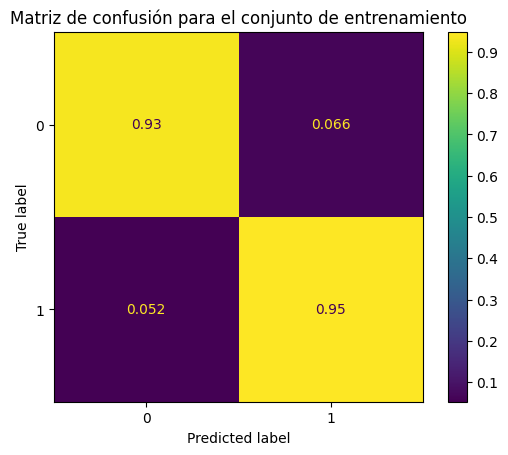

In [25]:
print('Precision:', precision_score(y_train, y_train_predict, pos_label=1))
print('Recall:', recall_score(y_train, y_train_predict, pos_label=1))
print('F1:', f1_score(y_train, y_train_predict, pos_label=1))

ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict, normalize='true')
plt.title('Matriz de confusión para el conjunto de entrenamiento')
plt.show()

A continuación se muestra la matriz de confusión para los datos de prueba:

Matriz de confusión para el conjunto de prueba
Precision: 0.8188976377952756
Recall: 0.8832271762208068
F1: 0.849846782431052


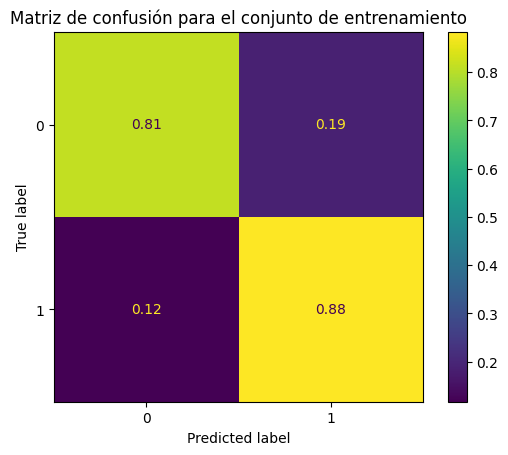

In [26]:
print("Matriz de confusión para el conjunto de prueba")
print('Precision:', precision_score(y_test, y_test_predict, pos_label=1))
print('Recall:', recall_score(y_test, y_test_predict, pos_label=1))
print('F1:', f1_score(y_test, y_test_predict, pos_label=1))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_predict, normalize='true')
plt.title('Matriz de confusión para el conjunto de entrenamiento')
plt.show()

Finalmente, estas son las métricas del modelo:

In [27]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       490
           1       0.82      0.88      0.85       471

    accuracy                           0.85       961
   macro avg       0.85      0.85      0.85       961
weighted avg       0.85      0.85      0.85       961



#### Conclusión final del algoritmo

Los resultados obtenidos a través de las matrices de evaluación indican que el proyecto ha logrado una predicción efectiva de aproximadamente el 85% ± 1%, evidenciado por el alto valor en las métricas de recall y precisión cercanos a 1. Estos resultados respaldan el desempeño general del proyecto y demuestran que el modelo es capaz de clasificar adecuadamente las opiniones de las películas.

## 3.2. Algoritmo de Naive Bayes (Multinomial)

El algoritmo de Bayes, más específicamente el de Naive Bayes se suele utilizar el los algoritmos de clasificación de texto, como lo es el la clasificación de satisfacción de un usuario basado en la reseña de una película, que se trata de una tarea de clasificación binaria. Multionomial Naive Bayes es una variante de Naive Bayes que tiene un mejor desempeño y es más comúnmente utilizado para datos discretos. En el caso de aplicación, el algoritmo de Multinomial Naive Bayes tiene diversas ventajas sobre otros algoritmos, dado que al realizar una implementación de Bag of Words mediante CountVectorizer, se tiene un conjunto de datos discretos que contemplan la frecuencia de ocurrencia de ciertas palabras o frases; adicionalmente MNB provée un factor de probabilidad para la clasificación de sentimientos que permite obtener mejores resultados en el análisis del sentimiento de una persona de acuerdo a las palabras de su reseña.

### Modelado

En específico en esta implementación se aplicó primero un CountVectorizer, como técnica de vectorización, que se encarga de tomar todas las reseñas preprocesadas, y convertirlas en una bolsa de palabras. Posteriormente se ejecuta el algoritmo Grid Search para la búsqueda del hiperparámetro 'alpha' del modelo Multinomial Naive Bayes, que representa un porcentaje de probabilidad adicional "ficticio" de la frecuencia de ciertas palabras o conjuntos de palabras, y que permite evitar que exista una probabilidad nula y así mejorar la precisión del modelo. 

In [28]:
# Convertir las reseñas en una bolsa de palabras
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(review)

# Dividir los datos en un conjunto de entrenamiento y un conjunto de prueba
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, sentimiento, test_size=0.2)

# Definir los posibles valores de hiperparámetros a probar
param_grid = {'alpha': [0.1] + [x/2 for x in range(1, 21)]} # [0.1, 0.5, 1.0, 1.5, ..., 9.5, 10.0]

# Definir el modelo de Naive Bayes
bys = MultinomialNB()

# Utilizar GridSearchCV para encontrar los mejores hiperparámetros
bys = GridSearchCV(bys, param_grid, cv=particiones, n_jobs=-1)
bys.fit(X_train2, y_train2)

# Obtener los mejores hiperparámetros y la precisión del modelo
best_params = bys.best_params_
accuracy = bys.best_score_
print("Best params: ", best_params)
print("Score: ", accuracy)

Best params:  {'alpha': 5.0}
Score:  0.8274343885281384


Debido a que alpha consiste en un hiperparámetro estocástico entre ciertos rangos debido a la naturaleza del algoritmo Naive Bayes, su valor escogido en el Grid Search puede variar en diferentes ejecuciones.

In [29]:
y_train_predict2 = bys.predict(X_train2)
y_test_predict2 = bys.predict(X_test2)

### Resultados del modelo

A continuación se muestra la matriz de confusión para los datos de entrenamiento:

Precision: 0.9545454545454546
Recall: 0.9304482225656878
F1: 0.9423428124184712


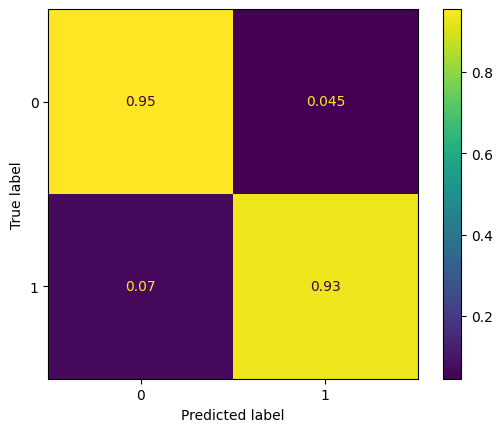

In [30]:
print('Precision:', precision_score(y_train2, y_train_predict2, pos_label=1))
print('Recall:', recall_score(y_train2, y_train_predict2, pos_label=1))
print('F1:', f1_score(y_train2, y_train_predict2, pos_label=1))

ConfusionMatrixDisplay.from_predictions(y_train2, y_train_predict2, normalize='true')

A continuación se muestra la matriz de confusión para los datos de prueba:

Precision: 0.7880085653104925
Recall: 0.8070175438596491
F1: 0.7973997833152762


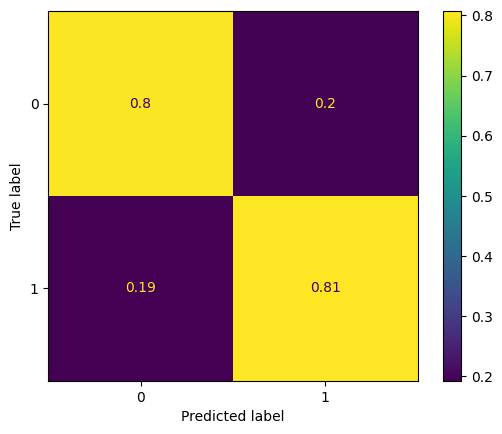

In [31]:
print('Precision:', precision_score(y_test2, y_test_predict2, pos_label=1))
print('Recall:', recall_score(y_test2, y_test_predict2, pos_label=1))
print('F1:', f1_score(y_test2, y_test_predict2, pos_label=1))

ConfusionMatrixDisplay.from_predictions(y_test2, y_test_predict2, normalize='true')

Finalmente, a continuación se presentan las métricas del modelo:

In [32]:
print(classification_report(y_test2, y_test_predict2))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       505
           1       0.79      0.81      0.80       456

    accuracy                           0.81       961
   macro avg       0.80      0.81      0.81       961
weighted avg       0.81      0.81      0.81       961



### Conclusión final del algoritmo

Según lo que se puede observar en las matrices de confusión presentadas anteriormente, y según el score obtenido anteriormente; se tiene una precisión promedio del modelo de alrededor del 82%, que es bastante buena. Así mismo, dentro del modelo el mejor valor para aplha seleccionado, se encuentra entre 2.5 y 4.5, con el fin de maximizar la precisión del algoritmo.

## 3.3. SVC

El algoritmo de Máquinas de Vectores de Soporte (SVM, por sus siglas en inglés) es un algoritmo de aprendizaje supervisado utilizado para la clasificación y regresión de datos. La idea principal detrás de SVM es encontrar un hiperplano en un espacio de alta dimensión que maximice la distancia entre las clases. El algoritmo SVM es útil para problemas de clasificación binaria y multiclase y puede manejar conjuntos de datos no lineales mediante el uso de un truco de kernel para transformar los datos a un espacio de mayor dimensión. La elección del kernel es un aspecto importante en el rendimiento del modelo SVM y se puede elegir entre diferentes tipos de kernels, como lineal, polinomial y radial. Además, el algoritmo SVM es eficiente en la clasificación de conjuntos de datos con muchas características. Sin embargo, puede ser sensible a la selección de hiperparámetros y requiere más recursos computacionales que otros algoritmos de aprendizaje supervisado.

### Modelado

El algoritmo SVC ofrece varias ventajas importantes para la clasificación de datos, incluyendo su eficacia en conjuntos de datos complejos y no linealmente separables, su capacidad para generalizar bien para nuevos datos, su flexibilidad en la elección de funciones kernel, su capacidad para manejar datos atípicos o ruido en los datos y su alta precisión en la clasificación binaria. En este caso, la implementación del algoritmo SVC en una tubería junto con la técnica de vectorización TfidfVectorizer y la búsqueda en cuadrícula de los mejores parámetros, permite maximizar las ventajas de este algoritmo y mejorar la precisión de la clasificación de opiniones de películas.

In [33]:
params_svc = {'clf__C': [1], 'clf__kernel': ['linear']}
tfidf = TfidfVectorizer()
svc_tfidf = Pipeline([('vect', tfidf), ('clf', SVC())])
svc_tfidf = GridSearchCV(svc_tfidf, params_svc, cv=particiones, n_jobs=-1, verbose=2)
svc_tfidf.fit(X_train, y_train)
# Se demora 6 minutos


Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', SVC())]),
             n_jobs=-1, param_grid={'clf__C': [1], 'clf__kernel': ['linear']},
             verbose=2)

### Resultados del modelo

In [34]:
score = svc_tfidf.score(X_test, y_test)
print("Best params: ", svc_tfidf.best_params_)
print("Score: ", score)


Best params:  {'clf__C': 1, 'clf__kernel': 'linear'}
Score:  0.841831425598335


In [35]:
y_train_predict = svc_tfidf.predict(X_train)
y_test_predict = svc_tfidf.predict(X_test)

Precision: 0.9828838174273858
Recall: 0.9839044652128764
F1: 0.9833938764919563


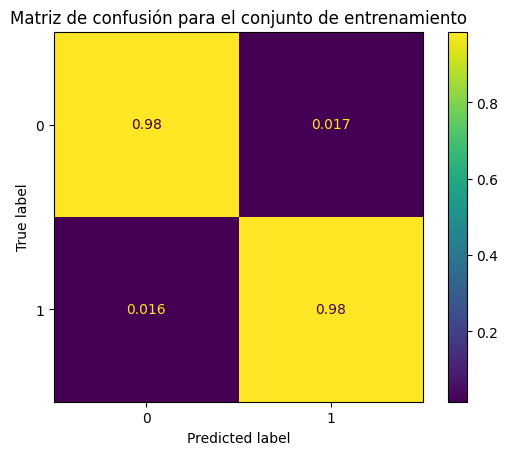

In [36]:
print('Precision:', precision_score(y_train, y_train_predict, pos_label=1))
print('Recall:', recall_score(y_train, y_train_predict, pos_label=1))
print('F1:', f1_score(y_train, y_train_predict, pos_label=1))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict, normalize='true')
plt.title('Matriz de confusión para el conjunto de entrenamiento')
plt.show()

Matriz de confusión para el conjunto de prueba
Precision: 0.8158415841584158
Recall: 0.8747346072186837
F1: 0.8442622950819672


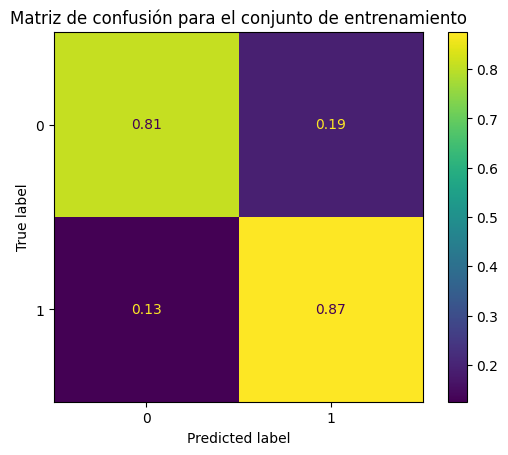

In [37]:
print("Matriz de confusión para el conjunto de prueba")
print('Precision:', precision_score(y_test, y_test_predict, pos_label=1))
print('Recall:', recall_score(y_test, y_test_predict, pos_label=1))
print('F1:', f1_score(y_test, y_test_predict, pos_label=1))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_predict, normalize='true')
plt.title('Matriz de confusión para el conjunto de entrenamiento')
plt.show()

Finalmente, a continuación se presentan las métricas del modelo:

In [38]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       490
           1       0.82      0.87      0.84       471

    accuracy                           0.84       961
   macro avg       0.84      0.84      0.84       961
weighted avg       0.84      0.84      0.84       961



#### Conclusión final del algoritmo

Como se puede observar en las matrices presentadas anteirormente, podemos observar como una precisión con los datos de test del 85%, lo que implica un resultado bueno y que permitirá al negocio hacer predicciones con respecto a las reseñas de una película. Este algorítmo tuvo como mejores parametros un C de 1, un y un kernel linear para maximizar la precisión. 

# Mejoras a partir de lo hablado con el experto

Al hablar con el experto nos mencionó que podíamos utilizar producto cruz entre conjuntos de hiperparametros y que esto nos permitiría mejorar nuestro modelo al evaluar todos los posibles hiperparámetros, esto lo hicimos con un gridsearch para mejorar la solución y eligiendo la mejor variable de cada uno de los conjuntos de hiperparametros para maximizar el porcentaje de precision.

Tambíen nos mencionó que podiamos intentar quitar el ruido o disminuir el ruido antes de ingresar la información al algorítmo, a lo que dijimos que ya habíamos realizado este proceso al hacer stemming, quitar las reseñas en inglés, quitar la puntuación y demás.

# Resultados

Después de observar las métricas obtenidas por los 3 diferentes algoritmos, se puede observar que el algoritmo más preciso y con un mejor rendimiento para los datos de entrada suministrados, es el algoritmo de *Regresión Logística* ya que este tiene una precisión promedio de alrededor del 85%. A continuación se construye el modelo final y se exporta en formato Joblib del algoritmo de regresión logística:

In [39]:

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stemmer = SnowballStemmer('spanish')
        self.p = inflect.engine()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        num_processes = os.cpu_count() or 2
        X_split = np.array_split(X, num_processes)
        X_processed = pd.concat(Parallel(n_jobs=num_processes)(delayed(self.process_data)(split) for split in X_split))
        return X_processed

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)
    
    def process_data(self, data):
        data_stemmed = data.apply(self.porter_stemmer_spanish)
        data_processed = data_stemmed.apply(self.preprocessing_parallel)
        data_processed = data_processed.apply(self.join_words)
        return data_processed

    def porter_stemmer_spanish(self, text):
        return [self.stemmer.stem(word) for word in text.split()]

    def join_words(self, words):
        return ' '.join(words)

    def remove_non_ascii(self, words):
        """Remove non-ASCII characters from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            new_words.append(new_word)
        return new_words

    def to_lowercase(self, words):
        """Convert all characters to lowercase from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = word.lower()
            new_words.append(new_word)
        return new_words

    def remove_punctuation(self, words):
        """Remove punctuation from list of tokenized words"""
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
        return new_words

    def replace_numbers(self, words):
        """Replace all integer occurrences in list of tokenized words with textual representation"""
        new_words = []
        for word in words:
            if word.isdigit():
                new_word = self.p.number_to_words(word)
                new_words.append(new_word)
            else:
                new_words.append(word)
        return new_words

    def preprocessing_parallel(self, words):
        words = self.to_lowercase(words)
        words = self.replace_numbers(words)
        words = self.remove_punctuation(words)
        words = self.remove_non_ascii(words)
        return words

text_preprocessor = TextPreprocessor()
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=5, max_df=0.7)
log_reg = LogisticRegression(C=10)

pipeline = make_pipeline(
    text_preprocessor,
    tfidf_vectorizer,
    log_reg
)

# fit the pipeline on the training data
pipeline.fit(review, sentimiento)

joblib.dump(pipeline, "best_model.joblib")

['best_model.joblib']

# Roles

### Brian Manuel Rivera:


Rol: líder de datos
Brian se encargó en su mayoría de la limpieza de datos, haciendo el tratamiento de las variables, vectorizando las reseñas de entrada, eliminado las palabras que generaran ruido, eliminando las reseñas en inglés y en general dejando los datos listos para poder ser utilizados por el resto del equipo. Brian realizó el algoritmo de Regresión Logística para intentar solucionar el proyecto planteado

### Tony Santiago Montes


Rol: líder de negocio y líder de analítica 
Tony se encargó de revisar los diferentes modelos y escoger el mejor modelo, en definir con qué métricas evaluaríamos los algoritmos realizados y verificar los estándares de calidad necesarios para la entrega del modelo que mejor se comporta. Además, Tony veló por resolver el problema del negocio y dirigir el equipo hacia el fin de completar la tarea que el negocio necesita. También fue el encargado de comunicarse con el experto de estadística y tener listas las preguntas así lograr un trabajo interdisciplinario con esta persona. Tony desarrollo el algoritmo de multinomial Naive Bayes para intentar solucionar el problema.

### Luccas Rojas


Rol: líder del proyecto
Luccas Rojas fue el encargado de dirigir el proyecto, establecer los días y horas de reunión entre todos los integrantes, en organizar los entregables del grupo y asignar las tareas que cada uno de los integrantes iba a realizar para que fuera lo más equitativo posible. Además, fue el que desarrolló el algoritmo de SVC para intentar solucionar el problema.


# Reflexión grupal

### Repartición de los 100 puntos

Tony Santiago Montes 33.3

Brian Manuel Rivera 33.3

Luccas Rojas 33.3

### Aspectos a mejorar

- Reunirnos mas seguido

- Definir los roles y el trabajo por hacer desde el principio 

- Mejorar la comunicación entre nosotros para coordinar las tareas y asi no llegar a repetir las tareas que otros ya realizaron

- Mejorar la cooperación del equipo para que todos nos ayudemos en las tareas y podamos aprender de lo que el otro hizo.

- Tenemos que mejorar también la motivación que tenemos con respecto a las actividades,  ya que llegamos a hacer el trabajo sólo por entregarlo.

- Debemos aprender a manejar mejor el tiempo para que nos rinda más y tengamos más tiempo para corregir lo errores.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b9916bc4-d763-4afb-9dbf-ca84bf74d9b6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>